In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
import seaborn as sns

import helper
import data_loading
import time

In [2]:
train_data, test_data, emotion_map = data_loading.get_data()
emotion_decode = {}

for emot, val in emotion_map.items():
    emotion_decode[val] = emot
print(emotion_map)
print(emotion_decode)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
28709 7178
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.module = nn.Sequential(
            nn.Conv2d(1, 16, (3, 3)),
            nn.ReLU(),

            nn.Conv2d(16, 16, (3, 3)),
            nn.ReLU(),
            
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, (3, 3)),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, (3, 3)),
            nn.ReLU(),
            
            nn.MaxPool2d(2),
            
            nn.Flatten(),
            
            nn.Linear(32 * 9 * 9, 512),
            nn.Tanh(),
            nn.Linear(512, 64),
            nn.Tanh(),
            nn.Linear(64, 7),
            nn.Softmax(dim=1)           
        )
    
    def forward(self, x):
        return self.module(x)
    
device = "cuda"
model = Model().to(device)

total_params = 0
for p in model.parameters():
    total_params += p.numel()
print(f"total_params : {total_params:,}")

total_params : 1,377,271


In [4]:
results = []

In [5]:
batch = 1024
epoch = 150
lr = 1e-4

results = list(results)

train_data_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch, shuffle=True)

loss_fn = nn.CrossEntropyLoss(helper.get_weight(train_data, device))
optimizer = torch.optim.Adam(model.parameters(), lr)

for _ in range(epoch):
    s = time.time()
    results.append(helper.fit(model, 
                              train_data_loader,
                              test_data_loader,
                              loss_fn,
                              optimizer,
                              device 
                            )
                    )
    e = time.time()
    e = round(e - s, 3)
    print(_, e, results[-1], sep = "\t")

250	5.901	[1.944776781674089, 7.036121077014176, 1.939626544713974, 12.803009194761772]
251	5.411	[1.93764944323178, 15.542164478038245, 1.917827531695366, 19.78266926720535]
252	5.323	[1.9260719973465492, 19.359782646556827, 1.9280743300914764, 23.000835887433826]


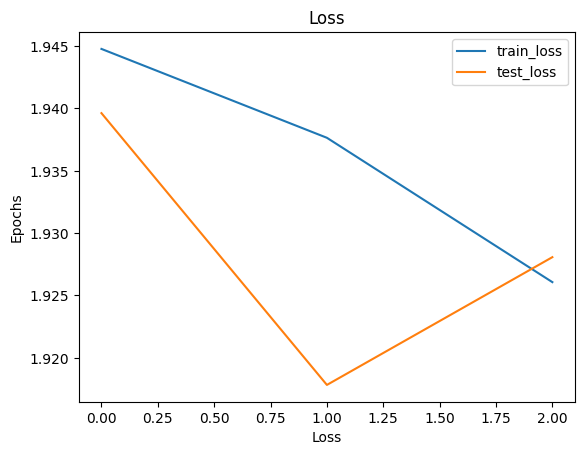

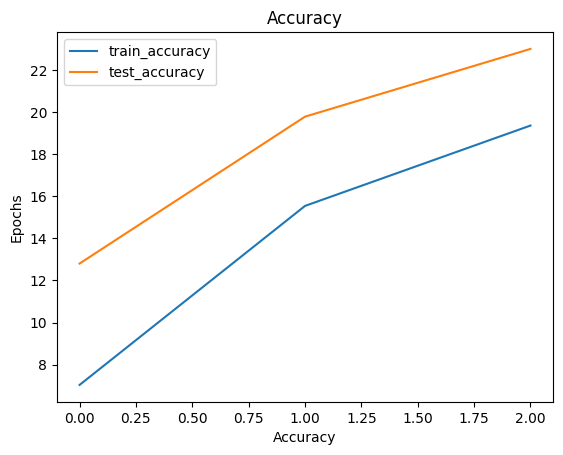

In [6]:
results = np.array(results)
helper.plot_result(results)

In [7]:
confusion_matrix = helper.make_confusion_matrix(model, test_data_loader, 7, "cuda")
confusion_matrix = confusion_matrix/confusion_matrix.sum()

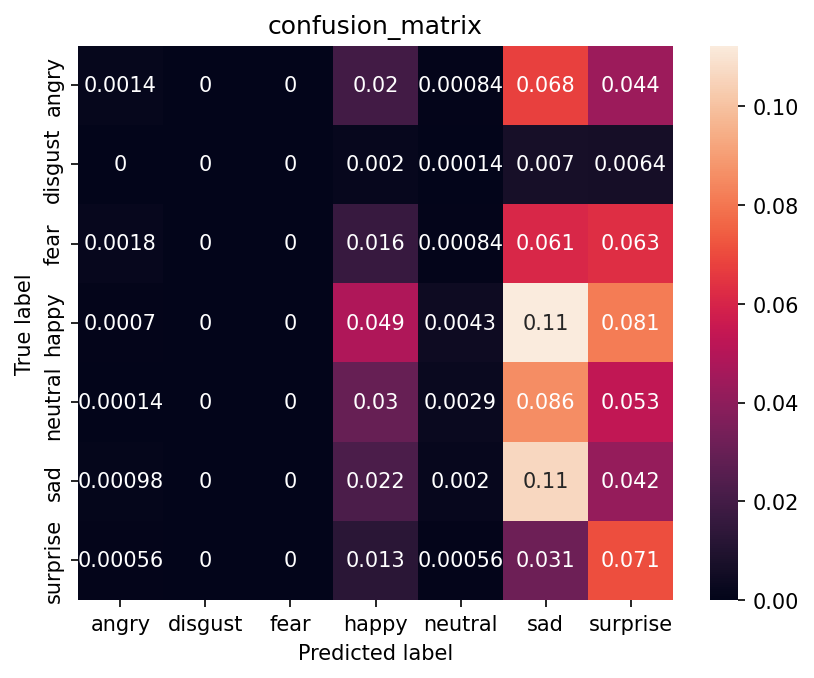

In [8]:
tick_label = [emotion_decode[i] for i in range(7)]
helper.plot_confusion_matrix(confusion_matrix, tick_label)

In [10]:
confusion_matrix

(tensor([[0.0014, 0.0000, 0.0000, 0.0196, 0.0008, 0.0680, 0.0436],
         [0.0000, 0.0000, 0.0000, 0.0020, 0.0001, 0.0070, 0.0064],
         [0.0018, 0.0000, 0.0000, 0.0163, 0.0008, 0.0607, 0.0630],
         [0.0007, 0.0000, 0.0000, 0.0486, 0.0043, 0.1123, 0.0812],
         [0.0001, 0.0000, 0.0000, 0.0298, 0.0029, 0.0855, 0.0534],
         [0.0010, 0.0000, 0.0000, 0.0223, 0.0020, 0.1064, 0.0421],
         [0.0006, 0.0000, 0.0000, 0.0125, 0.0006, 0.0315, 0.0706]]),
 tensor(1.0000))